# Simulating fNIRS data

In [7]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, uniform
sys.path.append("../") 
from src import HRF

(array([ 1.,  0.,  7., 12., 21., 20., 19., 14.,  5.,  1.]),
 array([-0.37112372, -0.28183999, -0.19255626, -0.10327253, -0.0139888 ,
         0.07529493,  0.16457866,  0.25386239,  0.34314612,  0.43242985,
         0.52171358]),
 <BarContainer object of 10 artists>)

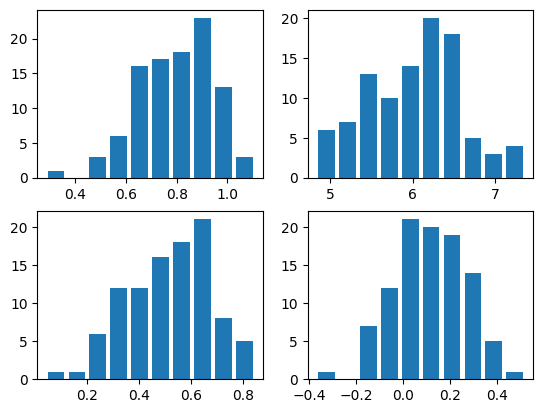

In [20]:
N_ITER = 100

adist = norm(0.80, 0.15).rvs(N_ITER)
ddist = norm(6, 0.5).rvs(N_ITER)
wdist = norm(0.5, 0.15).rvs(N_ITER)
rdist = norm(0.1, 0.15).rvs(N_ITER)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.hist(adist, rwidth=0.8)
ax2.hist(ddist, rwidth=0.8)
ax3.hist(wdist, rwidth=0.8)
ax4.hist(rdist, rwidth=0.8)

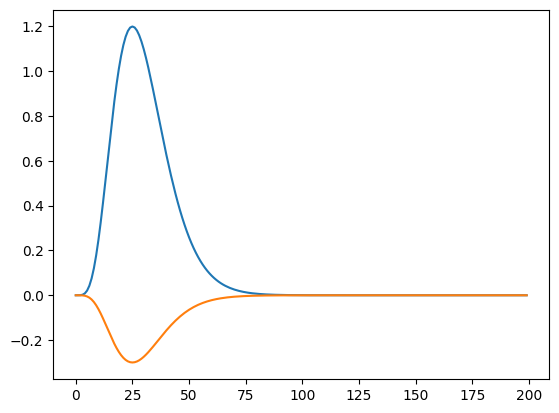

In [21]:
def hrf(time: np.ndarray = np.arange(0, 20, 0.1),
        amplitude: float = 1.2,
        peak_delay: float = 5.00,
        peak_width: float = 0.50,
        ratio: float = 0.80) -> np.ndarray:
    gamma = time ** peak_delay * np.exp(-time / peak_width)
    hbo = amplitude * gamma / gamma.max()
    hbr = -ratio * hbo
    return hbo, hbr

sfreq = 10
time = np.arange(0, 20, 1/sfreq)
hbo, hbr = hrf(time, ratio=0.25)

plt.plot(hbo)
plt.plot(hbr)

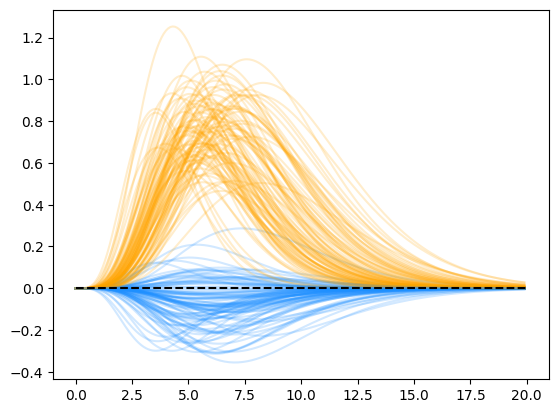

In [10]:
for (a, d, w, r) in zip(adist, ddist, wdist, rdist):
    hbo, hbr = hrf(time, a, d, w, r)
    plt.plot(time, hbr, c="dodgerblue", alpha=1/5)
    plt.plot(time, hbo, c="orange", alpha=1/5)
plt.hlines(y=[0], xmin=0, xmax=20,
           color="black", linestyles="dashed")
plt.show()

In [11]:
def sim_block(n_stim: int = 10,
              stim_duration: float = 0.8,
              isi: float = 1.5,
              silence_duration: int = 25):
    block_onsets = []
    block_offsets = []
    for _ in np.arange(n_blocks):
        onsets = np.cumsum(
            np.repeat([stim_duration + isi], n_stim))
        onsets = np.insert(onsets[0:-1], 0, 0)
        offsets = onsets + isi
    return onsets, offsets

In [14]:
condition_labels = ["A", "B"]
stim_duration = 270 * 3 / 1000
words_per_block = 10
n_blocks = 28
isi = [1.5, 0.5]
block_duration = np.sum(
    [stim_duration] * words_per_block +
    isi * int(words_per_block / 2))
ibi = [25, 35]  # inter-block interval (silence)
ibi_series = ibi * n_blocks
run_duration = np.sum([block_duration] * n_blocks + ibi * n_blocks)

onsets, offsets = sim_block()

onsets
offsets

array([ 1.5,  3.8,  6.1,  8.4, 10.7, 13. , 15.3, 17.6, 19.9, 22.2])

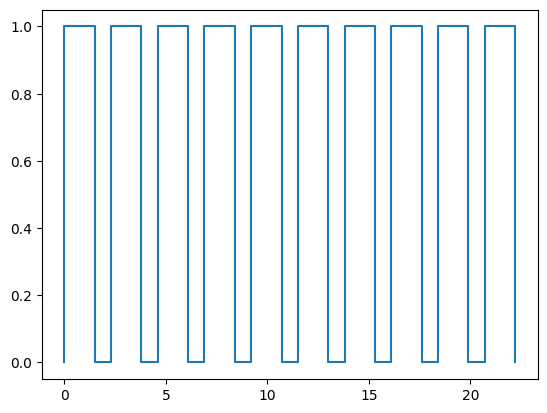

In [15]:
boxcar = np.hstack([[x, x, y, y] for (x, y) in zip(onsets, offsets)])
plt.plot(boxcar, np.hstack([[0, 1, 1, 0]
                            for _ in np.arange(len(onsets))]))
plt.show()

In [16]:
def sim_design(n_blocks: int = 28,
               ibi: int = 25,
               **kwargs):
    onsets = []
    offsets = []
    delay = 0
    for _ in np.arange(n_blocks):
        on, of = sim_block(**kwargs)
        onsets.append(on + delay)
        offsets.append(of + delay)
        delay = delay + on[1] + ibi
    return np.vstack(onsets), np.vstack(offsets)

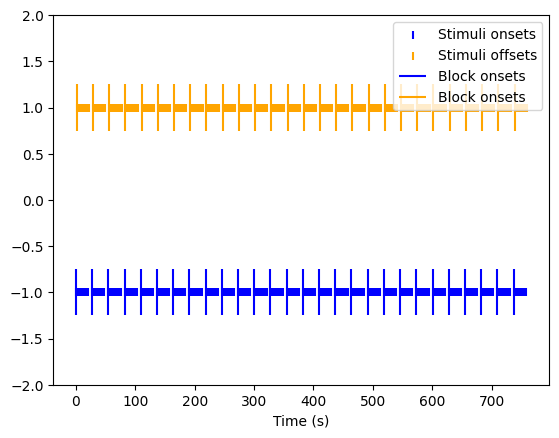

In [17]:
onset_design, offset_design = sim_design(n_blocks=n_blocks)
block_onsets = np.min(onset_design, axis=1)
block_offsets = np.min(offset_design, axis=1)
y_onsets = np.vstack([np.repeat(-1, len(x)) for x in onset_design])
y_offsets = np.vstack([np.repeat(1, len(x)) for x in offset_design])
plt.scatter(onset_design, y_onsets, marker="|",
            label="Stimuli onsets", color="blue")
plt.scatter(offset_design, y_offsets, marker="|",
            label="Stimuli offsets", color="orange")
plt.vlines(block_onsets, ymin=-1.25, ymax=-0.75,
           label="Block onsets", colors="blue")
plt.vlines(block_offsets, ymin=0.75, ymax=1.25,
           label="Block offsets", colors="orange")
plt.legend(loc="upper right")
plt.xlabel(xlabel="Time (s)")
plt.ylim([-2, 2])
plt.show()

In [22]:
# add signal
hrf_list = []
time_list = []
time = np.arange(0, 20, 0.1)
for o in onsets:
    adist = norm(0.80, 0.15).rvs(1)
    ddist = norm(6, 0.5).rvs(1)
    wdist = norm(0.5, 0.15).rvs(1)
    rdist = norm(0.1, 0.15).rvs(1)
    hrf_list.append(hrf(time, adist, ddist, wdist, rdist))
    time_list.append(o + time)

onsets, offsets = sim_block()
boxcar = np.hstack([[x, x, y, y]
                    for (x, y) in zip(onsets, offsets)])

[array([0.00000000e+00, 2.19720543e-08, 1.88965379e-06, 2.35763556e-05,
        1.33446027e-04, 4.89828828e-04, 1.36713659e-03, 3.15848347e-03,
        6.35408045e-03, 1.15008513e-02, 1.91515191e-02, 2.98116414e-02,
        4.38917219e-02, 6.16694313e-02, 8.32647432e-02, 1.08628795e-01,
        1.37545718e-01, 1.69645586e-01, 2.04426024e-01, 2.41279744e-01,
        2.79525379e-01, 3.18439209e-01, 3.57285781e-01, 3.95345899e-01,
        4.31940861e-01, 4.66452304e-01, 4.98337353e-01, 5.27139090e-01,
        5.52492607e-01, 5.74127058e-01, 5.91864257e-01, 6.05614414e-01,
        6.15369620e-01, 6.21195681e-01, 6.23222851e-01, 6.21635949e-01,
        6.16664306e-01, 6.08571873e-01, 5.97647792e-01, 5.84197628e-01,
        5.68535423e-01, 5.50976665e-01, 5.31832221e-01, 5.11403233e-01,
        4.89976971e-01, 4.67823587e-01, 4.45193691e-01, 4.22316696e-01,
        3.99399833e-01, 3.76627742e-01, 3.54162568e-01, 3.32144467e-01,
        3.10692438e-01, 2.89905422e-01, 2.69863589e-01, 2.506297

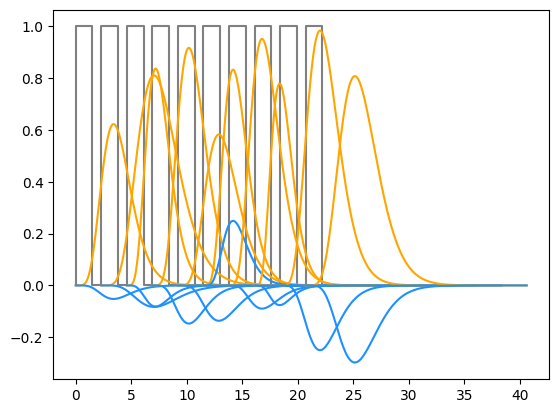

In [24]:
plt.plot(
    boxcar,
    np.hstack([[0, 1, 1, 0] for _ in np.arange(len(onsets))]),
    color="grey")

hbo_list = []
hbr_list = []
for t, (hbo, hbr) in zip(time_list, hrf_list):
    hbo_list.append(hbo)
    hbr_list.append(hbr)
    plt.plot(t, hbo, color="orange")
    plt.plot(t, hbr, color="dodgerblue")
    
    
hbo_list

In [26]:
def convolve_responses(times: np.ndarray,
                       values: np.ndarray,
                       sfreq: float = 10,
                       n: int = 25) -> np.ndarray:
    conv = []
    times = []
    for idx, (t, signal) in enumerate(zip(time_list, values)):
        pad1 = len(np.arange(0, np.min(t), 1/sfreq))
        pad2 = len(np.arange(np.max(t), np.max(time_list), 1/sfreq))
        s = np.hstack([np.zeros([pad1, ]),
                       signal,
                       np.zeros([pad2, ])])
        if idx != 0:
            s = s[0:np.min([len(x) for x in conv])]
        conv.append(s)
    conv_signal = np.sum(np.vstack(conv), 0)
    conv_time = np.linspace(0, np.max(time_list), len(conv_signal))
    return conv_signal, conv_time

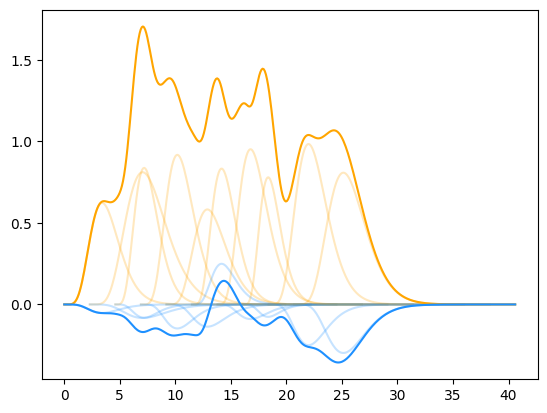

In [27]:
hbo_conv, times_conv = convolve_responses(time_list, hbo_list)
hbr_conv, _ = convolve_responses(time_list, hbr_list)

for t, (hbo, hbr) in zip(time_list, hrf_list):
    hbo_list.append(hbo)
    hbr_list.append(hbr)
    plt.plot(t, hbo, color="orange", alpha=1/4)
    plt.plot(t, hbr, color="dodgerblue", alpha=1/4)
plt.plot(times_conv, hbo_conv, color="orange")
plt.plot(times_conv, hbr_conv, color="dodgerblue")
plt.show()

In [28]:
def generate_noise(signal: np.ndarray,
                   time: np.ndarray,
                   type: str = "white",
                   sfreq: int = 10):
    n_samples = len(signal)
    if type == "white":
        return norm(0.0, 0.2).rvs(size=n_samples)
    else:
        if type == "heart":
            freq = np.random.normal(1.5, 0.2)
            inc = np.random.uniform(1.03, 1.10)
        if type == "respiration":
            freq = np.random.normal(0.25, 0.05)
            inc = np.random.uniform(1.03, 1.10)
        if type == "mayer":
            freq = np.random.normal(0.1, 0.02)
            inc = np.random.uniform(1.03, 1.10)
        return np.sin(time * freq / sfreq * np.pi * inc)

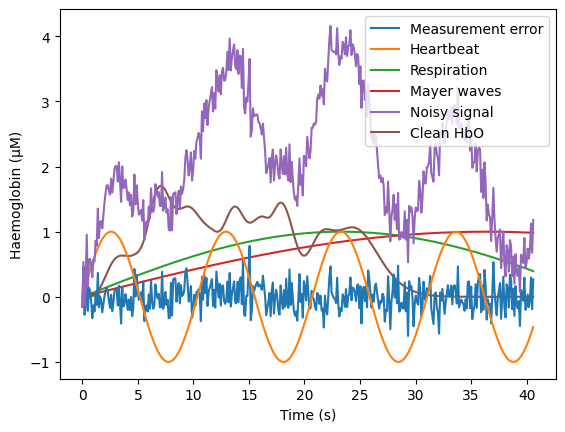

In [29]:
heart_noise = generate_noise(hbo_conv,
                             times_conv, type="heart")
resp_noise = generate_noise(hbo_conv,
                            times_conv, type="respiration")
mayer_noise = generate_noise(hbo_conv,
                             times_conv, type="mayer")
white_noise = generate_noise(hbo_conv, times_conv, type="white")
hbo_noise = np.sum([hbo_conv, white_noise, heart_noise,
                    resp_noise, mayer_noise], 0)
plt.plot(times_conv, white_noise, label="Measurement error")
plt.plot(times_conv, heart_noise, label="Heartbeat")
plt.plot(times_conv, resp_noise, label="Respiration", zorder=0)
plt.plot(times_conv, mayer_noise, label="Mayer waves", zorder=0)
plt.plot(times_conv, hbo_noise, label="Noisy signal")
plt.plot(times_conv, hbo_conv, label="Clean HbO", zorder=0)
plt.legend(loc="upper right")
plt.xlabel(xlabel="Time (s)")
plt.ylabel(ylabel="Haemoglobin (μM)")
plt.show()

In [30]:
def sim_channel(onsets: np.ndarray, sfreq: float = 10):
    hrf_list = []
    time_list = []
    for o in onsets:
        t = np.arange(0, 20, 1/sfreq)
        adist = norm(0.80, 0.15).rvs(1)
        ddist = norm(6, 0.5).rvs(1)
        wdist = norm(1, 0.15).rvs(1)
        rdist = norm(0.1, 0.15).rvs(1)
        hrf_list.append(hrf(t, adist, ddist, wdist, rdist))
        time_list.append(np.min(o) + t)

    hbo_list = []
    hbr_list = []
    for (hbo, hbr) in hrf_list:
        hbo_list.append(hbo)
        hbr_list.append(hbr)
    hbo_conv, times_conv = convolve_responses(time_list, hbo_list)
    hbr_conv, _ = convolve_responses(time_list, hbr_list)
    heart_noise = generate_noise(hbo_conv,
                                 times_conv, type="heart")
    resp_noise = generate_noise(hbo_conv,
                                times_conv, type="respiration")
    mayer_noise = generate_noise(hbo_conv,
                                 times_conv, type="mayer")
    white_noise = generate_noise(hbo_conv, times_conv, type="white")
    hbo = np.sum([hbo_conv, white_noise, heart_noise,
                  resp_noise, mayer_noise], 0)
    hbr = np.sum([hbr_conv, white_noise, -heart_noise,
                  -resp_noise, -mayer_noise], 0)
    return hbo, hbr, times_conv

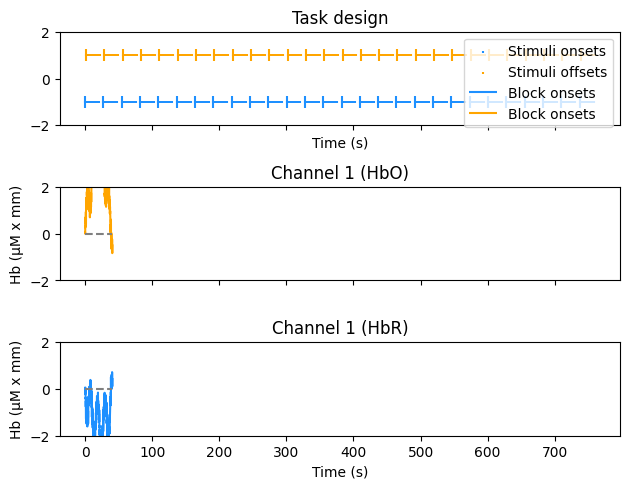

In [31]:
hbo, hbr, times = sim_channel(onset_design)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

onset_design, offset_design = sim_design(n_blocks=n_blocks)
block_onsets = np.min(onset_design, axis=1)
block_offsets = np.min(offset_design, axis=1)
y_onsets = np.vstack([np.repeat(-1, len(x)) for x in onset_design])
y_offsets = np.vstack([np.repeat(1, len(x)) for x in offset_design])
ax1.scatter(onset_design, y_onsets, marker="|", s=2,
            label="Stimuli onsets", color="dodgerblue")
ax1.scatter(offset_design, y_offsets, marker="|", s=1,
            label="Stimuli offsets", color="orange")
ax1.vlines(block_onsets, ymin=-1.25, ymax=-0.75,
           label="Block onsets", colors="dodgerblue")
ax1.vlines(block_offsets, ymin=0.75, ymax=1.25,
           label="Block onsets", colors="orange")
ax1.legend(loc="upper right")
ax1.set_xlabel(xlabel="Time (s)")
ax1.set_title("Task design")
ax1.set_ylim([-2, 2])

ax2.plot(times, hbo, label="HbO", color="orange")
ax2.hlines(y=[0], xmin=0, xmax=np.max(times),
           color="grey", linestyles="dashed")
ax2.set_ylabel(ylabel="Hb (μM x mm)")
ax2.set_title("Channel 1 (HbO)")

ax3.plot(times, hbr, label="HbR", color="dodgerblue")
ax3.hlines(y=[0], xmin=0, xmax=np.max(times),
           color="grey", linestyles="dashed")
ax3.set_ylabel(ylabel="Hb (μM x mm)")
ax3.set_title("Channel 1 (HbR)")
plt.tight_layout()
plt.xlabel(xlabel="Time (s)")
plt.title("Channel 1 (HbR)")
plt.show()

In [32]:
def sim_dataset(onsets: np.ndarray,
                n_channels: int = 10):
    ch_names = ["Ch" + str(x) for x in np.arange(n_channels)]
    time_list = []
    dataset = []
    for ch in ch_names:
        hbo, hbr, times = sim_channel(onsets)
        dataset.append(hbo)
        dataset.append(hbr)
        time_list.append(times)
    ch_names = [x + y for x in ch_names for y in [" HbO", " HbR"]]
    times = [times] * len(dataset)
    return dataset, times, ch_names

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_5860\2688192778.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


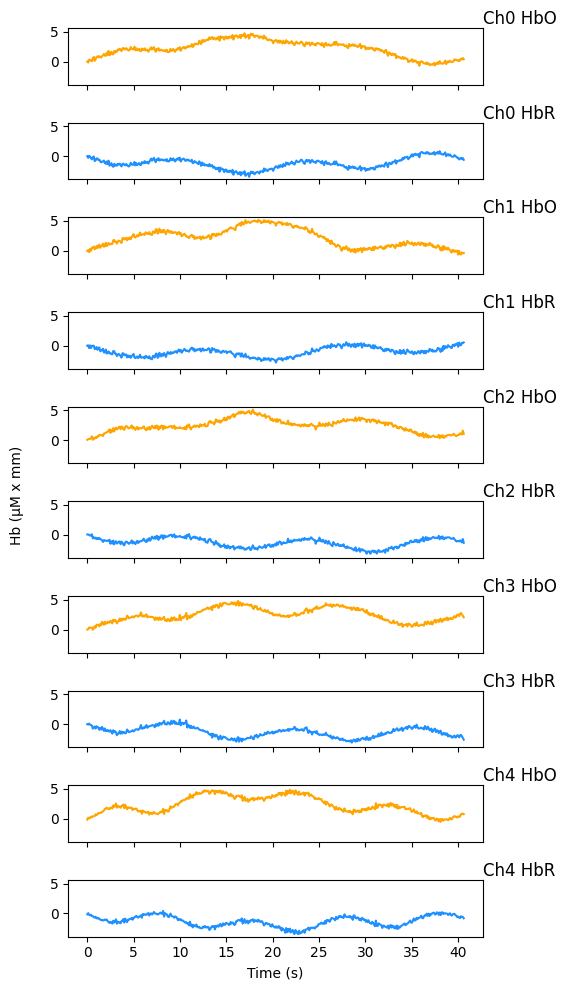

In [33]:
N_CHANNELS = 5
dataset, times, ch_names = sim_dataset(onset_design, n_channels=N_CHANNELS)

fig, ax = plt.subplots(nrows=N_CHANNELS*2,
                       ncols=1,
                       sharex=True,
                       sharey=True,
                       layout="constrained")

for idx, (d, t, c) in enumerate(zip(dataset, times, ch_names)):
    color = "orange" if "HbO" in c else "dodgerblue"
    ax[idx].plot(t, np.transpose(d), color=color)
    ax[idx].set_title(c, position=(1, 0), ha="left", va="top")
fig.text(-0.05, 0.5,
         "Hb (μM x mm)",
         va="center",
         rotation="vertical")
fig.set_size_inches(5, 10, forward=True)
plt.xlabel(xlabel="Time (s)")

plt.tight_layout()